In [23]:
#import statements
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use("fivethirtyeight")
import seaborn as sns
import scipy as scipy
from sklearn.linear_model import LinearRegression
import math

%matplotlib inline

In [24]:
#freshmen is a DataFrame that holds admissions data for the entire UC system from 1994 to 2017 
#Source: https://www.universityofcalifornia.edu/infocenter/admissions-residency-and-ethnicity
freshmen = pd.read_csv("../data/freshmen.csv")
freshmen.head(60)

,Calculation1,Campus,City,County/State/ Territory,Fall Term,School,Sch Src FR,Uad Uc Ethn 6 Cat,adm (SUM),app (SUM),enr (SUM)
0,F BRAVO MEDICAL MAGNET HS51719,Riverside,Los Angeles,Los Angeles,2008,F BRAVO MEDICAL MAGNET HS,California Public High School,Hispanic/ Latino,39.0,50,10.0
1,ARAGON HIGH SCHOOL53163,Santa Barbara,San Mateo,San Mateo,2012,ARAGON HIGH SCHOOL,California Public High School,Asian,28.0,53,4.0
2,ETIWANDA HIGH SCHOOL50888,San Diego,Etiwanda,San Bernardino,2012,ETIWANDA HIGH SCHOOL,California Public High School,Asian,11.0,34,4.0
3,UPLAND HIGH SCHOOL53586,Merced,Upland,San Bernardino,2005,UPLAND HIGH SCHOOL,California Public High School,Asian,6.0,7,NaN
4,MORNINGSIDE HIGH SCHOOL51262,Los Angeles,Inglewood,Los Angeles,2006,MORNINGSIDE HIGH SCHOOL,California Public High School,All,5.0,22,NaN
5,SAN JOSE HIGH SCHOOL53098,Davis,San Jose,Santa Clara,2008,SAN JOSE HIGH SCHOOL,California Public High School,Asian,7.0,9,NaN
6,MIDDLE COLLEGE HIGH SCHOOL53204,Los Angeles,San Pablo,Contra Costa,2003,MIDDLE COLLEGE HIGH SCHOOL,California Public High School,Asian,4.0,6,NaN
7,BROOKWOOD HIGH SCHOOL112754,Universitywide,Snellville,Georgia,2016,BROOKWOOD HIGH SCHOOL,Non-CA Domestic High School,All,5.0,8,NaN
8,CHAFFEY HIGH SCHOOL52275,Universitywide,Ontario,San Bernardino,2011,CHAFFEY HIGH SCHOOL,California Public High School,Asian,6.0,8,3.0
9,VICTOR VALLEY HIGH SCHOOL53660,Universitywide,Victorville,San Bernardino,1999,VICTOR VALLEY HIGH SCHOOL,California Public High School,Asian,4.0,5,3.0


In [25]:
#a function that selects rows from data frame df that have values for the columns col_names in the list col_vals
def df_filter(df, col_names, col_vals_list):
    assert len(col_names) == len(col_vals_list), "lists must be same size:"+str(len(col_names))+", "+str(len(col_vals_list))
    
    new_df = df.iloc[:]
    for i in range(len(col_names)):
        col_name, col_vals = col_names[i], col_vals_list[i]
        new_df = new_df.iloc[:][new_df[col_name].isin(col_vals)]
    return new_df

In [26]:
freshmen_2001 = df_filter(freshmen, ['Fall Term'],[[2001]]) 
freshmen_2001.describe()
#key takeaways:
    #20,382 students applied to the UCs in 2001
    #an average of over 24 students applied to the UCs per school

,Fall Term,adm (SUM),app (SUM),enr (SUM)
count,20382.0,17371.000000,20382.000000,8835.000000
mean,2001.0,16.662944,24.189677,10.653537
std,0.0,22.091722,29.815772,15.302350
min,2001.0,3.000000,5.000000,3.000000
25%,2001.0,5.000000,8.000000,4.000000
50%,2001.0,9.000000,14.000000,6.000000
75%,2001.0,19.000000,28.000000,11.000000
max,2001.0,384.000000,423.000000,283.000000


In [27]:
#import database regarding wealth distributions from different counties 
#Source: https://datausa.io/profile/geo/california/#economy
county_wealth = pd.read_csv("../data/CA County Wealth Data.csv")
#create a copy of the county_wealth database that removes the discrepancies between county names and removes the "geo" column
county_wealth = county_wealth.iloc[:, [0, 1, 3]]
for i in range(len(county_wealth)):
    index = county_wealth.iloc[i, 1].find("County") 
    if (index != -1):
        county_wealth.iloc[i, 1] = county_wealth.iloc[i, 1][:index].strip()
    else:
        county_wealth.iloc[i, 1] = county_wealth.iloc[i, 1][:].strip()

county_wealth.head()

,year,geo_name,income
0,2013,Alameda,72112.0
1,2013,Alpine,58636.0
2,2013,Amador,53684.0
3,2013,Butte,43752.0
4,2013,Calaveras,55295.0


In [28]:
def income_dict_gen(county_wealth, year_in):
    if not(year_in >= 2013 and year_in <= 2016):
        year_in = 2016
    #create a copy of the wealth database with only data from the year year_in
    def county_wealth_in_year(df):
        return df.iloc[:][df['year'].isin([year_in])] 
    #create a copy of the wealth database with only data from year_in and excluding the 'geo' column
    county_year = county_wealth_in_year(county_wealth)
    
    #transform this into a dictionary formatted like this:
    #   {county: income}
    county_income_dict = {}
    for i in range(len(county_year)):
        county_income_dict[county_year.iloc[i, 1]] = county_year.iloc[i, 2]
    return county_income_dict

In [29]:
def print_admissions_numbers(df):
    for i in range(len(df)):
        school = df.iloc[i]
        if (not(math.isnan(school["enr (SUM)"]))):
            print("{school:35s} -> applied:{applied:4.0f}  /  admitted:{admitted:3.0f}  /  enrolled:{enrollees:3.0f}".format(
                school = school["School"], 
                applied = school["app (SUM)"],
                admitted = school["adm (SUM)"],
                enrollees = school["enr (SUM)"]
            ))

In [30]:
#Create a DataFrame that takes in the counts of application, admittance, and enrollment for all schools in a given county,
# and then concatenates data from the wealth data of the county to draw socioeconomic conclusions about admissions rate

#format for dictionary county_dict => {'County': [Applied, Admitted, Enrolled, Income]}

def income_vs_admit_df_gen(df, county_income_dict):
    county_dict = {}
    for i in range(len(df)):
        county = df.iloc[i]
        county_name = county[0]
        #create the entry in the dict for a county if it doesn't already exist
        if (county_name not in county_dict):
            county_dict[county_name] = [0, 0, 0, county_income_dict[county_name]/10000]
        #update the entry for the county with the school's data
        num_applied, num_admitted, num_enrolled = df.iloc[i][3], df.iloc[i][2], df.iloc[i][4]
        county_num_applied, county_num_admitted, county_num_enrolled = county_dict[county_name][0], county_dict[county_name][1], county_dict[county_name][2]
        county_dict[county_name][0] = county_num_applied  + num_applied
        county_dict[county_name][1] = county_num_admitted + num_admitted
        county_dict[county_name][2] = county_num_enrolled + num_enrolled    
    return pd.DataFrame(data=county_dict)

In [31]:
def print_regression(xdat, ydat, label):
    #print introduction
    print ("Regression Equations For:", label)
    #calculate regression variables
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=xdat, y=ydat)
    #print regression equation
    print("Linear Regression Equation:", str(round(slope, 2)) + 'x + ' + str(round(intercept, 2)),
          "\nr^2:", str(round(pow(r_value, 2), 4)), "p-value:", str(round(p_value, 4)))
    return [round(slope, 4), round(intercept, 4)]

In [39]:
def plot_wealth_vs_data(year, wealth_array, ydata, label, log=False, percentage=False, robust_in=False, title_addition=""):
    sns.regplot(wealth_array, ydata[0], label=label[0], ci=None, scatter=True, truncate=True, robust=robust_in)
    sns.regplot(wealth_array, ydata[1], label=label[1], ci=None, scatter=True, truncate=True, robust=robust_in)
    sns.regplot(wealth_array, ydata[2], label=label[2], ci=None, scatter=True, truncate=True, robust=robust_in)
    #title, scale, and ylabel decision-making
    if log:
        plt.yscale('log')
        plt.xscale('log')
        titl = 'Log-Scaled'
    else:
        titl = 'Natural Scale'
        
    if percentage:
        titl = titl + ' Percentage'
        plt.ylabel('Percentage of Students')
    else:
        titl = titl + ' Raw Numbers'
        plt.ylabel('Number of Students')
    
    titl = titl + title_addition + " in " + str(year)
    #show the graph
    plt.title(titl)
    plt.xlabel('Median Household Income of County (in $10,000)')
    plt.legend()
    plt.savefig("../images/" + titl + ".png", bbox_inches='tight', dpi=300)
    plt.show()
    #print slope information
    rpvals = []
    rpvals.append(print_regression(wealth_array, ydata[0], label[0]))
    rpvals.append(print_regression(wealth_array, ydata[1], label[1]))
    rpvals.append(print_regression(wealth_array, ydata[2], label[2]))
    print("\n")
    return rpvals

In [40]:
def plot_graphs(county_admissions_and_income, year):
    #graph the data generated from the county_admissions_and_income DataFrame using matplotlib
    #convert data to np arrays
    county_name_array = county_admissions_and_income.columns.values
    county_applied_array = county_admissions_and_income.iloc[0].values
    county_admitted_array = county_admissions_and_income.iloc[1].values
    county_enrollment_array = county_admissions_and_income.iloc[2].values
    county_wealth_array = county_admissions_and_income.iloc[3].values
    
    rpvals2 = []


    ###############################################################################################################################
    #############################                            RAW NUMBERS                              #############################
    ###############################################################################################################################

    #list form for data for applied v. wealth, admitted v. wealth, and enrolled v. wealth
    #simple_graph_labels = ['applied', 'admitted', 'enrolled']
    #simple_graph_ydata = [county_applied_array, county_admitted_array, county_enrollment_array]

    #plot the data as is with a trendline, with regular scaling
    #a = plot_wealth_vs_data(year, county_wealth_array, simple_graph_ydata, simple_graph_labels, False, False)
    #rpvals2.append(a)
    
    #plot the data with a trendline, this time with a double-axis log
    #a = plot_wealth_vs_data(year, county_wealth_array, simple_graph_ydata, simple_graph_labels, True, False)
    #rpvals2.append(a)

    ###############################################################################################################################
    #############################                            PERCENTAGES                              #############################
    ###############################################################################################################################


    admitted_to_applied_percentage = county_admitted_array/county_applied_array*100
    enrolled_to_applied_percentage = county_enrollment_array/county_applied_array*100
    enrolled_to_admitted_percentage = county_enrollment_array/county_admitted_array*100

    #list form for data for admitted to applied v. wealth, enrolled to applied v. wealth, and enrolled to admitted v. wealth
    ratio_graph_labels = ['admitted to applied', 'enrolled to applied', 'enrolled to admitted']
    ratio_graph_ydata = [admitted_to_applied_percentage, enrolled_to_applied_percentage, enrolled_to_admitted_percentage]

    #plot the data as is with a trendline, with regular scaling
    a = plot_wealth_vs_data(year, county_wealth_array, ratio_graph_ydata, ratio_graph_labels, False, True)
    rpvals2.append(a)
    
    #plot the data with a trendline, this time with a double-axis log
    #a = plot_wealth_vs_data(year, county_wealth_array, ratio_graph_ydata, ratio_graph_labels, True, True)
    #rpvals2.append(a)
    

    ###############################################################################################################################
    #############################                        ROBUST PERCENTAGES                           #############################
    ###############################################################################################################################


    #list form for data for admitted to applied v. wealth, enrolled to applied v. wealth, and enrolled to admitted v. wealth
    #robust_graph_labels = ['admitted to applied', 'enrolled to applied', 'enrolled to admitted']
    #robust_graph_ydata = [admitted_to_applied_percentage, enrolled_to_applied_percentage, enrolled_to_admitted_percentage]

    #plot the data as is with a trendline, with regular scaling
    #a = plot_wealth_vs_data(year, county_wealth_array, robust_graph_ydata, robust_graph_labels, False, False, True, " Robust")
    #rpvals2.append(a)
    
    #plot the data with a trendline, this time with a double-axis log
    #a = plot_wealth_vs_data(year, county_wealth_array, robust_graph_ydata, robust_graph_labels, True, False, True, " Robust")
    #rpvals2.append(a)
    
    return rpvals2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


   Santa Clara  San Bernardino  Contra Costa  San Francisco  Santa Cruz  \
0    2798.0000        197.0000     1603.0000      1235.0000    123.0000   
1     872.0000         67.0000      508.0000       239.0000     45.0000   
2     457.0000         34.0000      267.0000       186.0000     33.0000   
3      10.1173          5.4469        8.2881         8.7701      7.0088   

   Sacramento  San Diego    Alameda   Ventura  Los Angeles    ...     \
0    644.0000  1538.0000  2214.0000  330.0000    6510.0000    ...      
1    244.0000   509.0000   713.0000  125.0000    2016.0000    ...      
2    129.0000   250.0000   425.0000   75.0000     933.0000    ...      
3      5.7509     6.6529     7.9831    7.8593       5.7952    ...      

   San Joaquin    Fresno  Stanislaus     Kern   Kings  El Dorado   Placer  \
0     140.0000  203.0000     83.0000  72.0000  7.0000    13.0000  34.0000   
1      58.0000   99.0000     40.0000  24.0000  3.0000     5.0000  16.0000   
2      29.0000   44.0000     24.

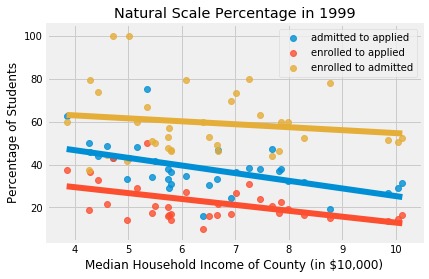

Regression Equations For: admitted to applied
Linear Regression Equation: -3.57x + 60.98 
r^2: 0.2834 p-value: 0.001
Regression Equations For: enrolled to applied
Linear Regression Equation: -2.76x + 40.46 
r^2: 0.2295 p-value: 0.0036
Regression Equations For: enrolled to admitted
Linear Regression Equation: -1.38x + 68.43 
r^2: 0.0223 p-value: 0.3919




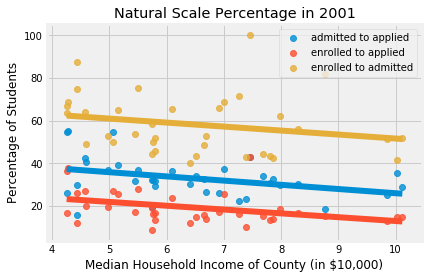

Regression Equations For: admitted to applied
Linear Regression Equation: -1.97x + 45.71 
r^2: 0.1288 p-value: 0.0316
Regression Equations For: enrolled to applied
Linear Regression Equation: -1.79x + 30.9 
r^2: 0.1438 p-value: 0.0226
Regression Equations For: enrolled to admitted
Linear Regression Equation: -1.87x + 70.35 
r^2: 0.0483 p-value: 0.198


[[[-3.5739, 60.9829], [-2.757, 40.4565], [-1.3789, 68.4324]]]
[[[-1.971, 45.7147], [-1.7922, 30.895], [-1.8722, 70.3543]]]
[[[-1.6029, 15.2682], [-0.9648, 9.5615], [0.4933, -1.9219]]]


In [41]:
county_income_dict_1999 = income_dict_gen(county_wealth, 1999)
county_income_dict_2001 = income_dict_gen(county_wealth, 2001)
#print(county_income_dict)

#ca_pu_2001_berk and ca_pu_1999_berk are dataframes that hold acceptance numbers for schools that have students
# who enrolled in the 2001 and 1999 fall terms, respectively, to UC Berkeley. 

#Column 0 -> County/State/Territory   -> County of Origin for the high school
#Column 1 -> School                   -> School Name
#Column 2 -> adm (SUM)                -> number of students from the school admitted
#Column 3 -> app (SUM)                -> number of students from the school who applied
#Column 4 -> enr (SUM)                -> number of students from the school who enrolled

#filter Year to 2001, School Type to CA Public, Campus to UCB, exclude schools with no enrolled students, and have only ^ columns 
ca_pub_2001_berk = df_filter(freshmen, ['Fall Term', 'Sch Src FR', 'Campus'], [[2001], ['California Public High School'], ['Berkeley']]).iloc[:, [3, 5, 8, 9, 10]][freshmen['enr (SUM)'] > 0]
ca_pub_1999_berk = df_filter(freshmen, ['Fall Term', 'Sch Src FR', 'Campus'], [[1999], ['California Public High School'], ['Berkeley']]).iloc[:, [3, 5, 8, 9, 10]][freshmen['enr (SUM)'] > 0]

#print_admissions_numbers(ca_pub_1999_berk)
#print_admissions_numbers(ca_pub_2001_berk)

county_admissions_and_income_1999 = income_vs_admit_df_gen(ca_pub_1999_berk, county_income_dict_1999)
county_admissions_and_income_2001 = income_vs_admit_df_gen(ca_pub_2001_berk, county_income_dict_2001)
print(county_admissions_and_income_1999)
print(county_admissions_and_income_1999.iloc[2]/county_admissions_and_income_1999.iloc[1]*100)
#print(county_admissions_and_income_2001)

rpvals1999 = plot_graphs(county_admissions_and_income_1999, 1999)
rpvals2001 = plot_graphs(county_admissions_and_income_2001, 2001)
print(rpvals1999)
print(rpvals2001)

def subtract_items_in_lists(list1, list2):
    assert len(list1)==len(list2), "need to be equal length lists"
    out_list = []
    for i in range(len(list1)):
        item1 = list1[i]
        item2 = list2[i]
        if type(item1)==list:
            out_list.append(subtract_items_in_lists(item1, item2))
        else:
            out_list.append(round(item1 - item2, 4))
    return out_list

print(subtract_items_in_lists(rpvals1999, rpvals2001))

In [38]:
wealth_counties_1999 = county_admissions_and_income_1999.loc[3]

In [14]:
applied_counties_1999 = county_admissions_and_income_1999.loc[0]
admitted_counties_1999 = county_admissions_and_income_1999.loc[1]
enrolled_counties_1999 = county_admissions_and_income_1999.loc[2]

In [15]:
wealth_yield_1999 = pd.DataFrame(data={"wealth": wealth_counties_1999, "enrolled/admitted":enrolled_counties_1999/admitted_counties_1999*100})
wealth_yield_1999

,wealth,enrolled/admitted
Santa Clara,10.1173,52.408257
San Bernardino,5.4469,50.746269
Contra Costa,8.2881,52.559055
San Francisco,8.7701,77.824268
Santa Cruz,7.0088,73.333333
Sacramento,5.7509,52.868852
San Diego,6.6529,49.115914
Alameda,7.9831,59.607293
Ventura,7.8593,60.000000
Los Angeles,5.7952,46.279762


In [16]:
def fit_line(tbl):
    r = correlation(tbl)
    slope = r * np.std(tbl.iloc[:,1])/np.std(tbl.iloc[:,0])
    intercept = np.mean(tbl.iloc[:,1]) - slope * np.mean(tbl.iloc[:,0])
    return [slope, intercept]
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)
def correlation(tbl):
    x_co_standard = standard_units(tbl.iloc[:,0])
    y_co_standard = standard_units(tbl.iloc[:,1])
    return np.mean(x_co_standard * y_co_standard)

In [17]:
def bootstrap_lines(tbl, num_bootstraps):
    slope_arr = np.array([])
    intercept_arr = np.array([])
    for _ in range(num_bootstraps):
        new_tbl = tbl.sample(frac=1, replace=True)
        new_slope, new_intercept = fit_line(new_tbl)
        slope_arr = np.append(slope_arr, new_slope)
        intercept_arr = np.append(intercept_arr, new_intercept)
    
    return pd.DataFrame(data={"slope": slope_arr, "intercept": intercept_arr})

In [18]:
np.random.seed(2)

In [19]:
slopes_intercepts_1999 = bootstrap_lines(wealth_applied_1999, 100)

slope_2_5 = np.percentile(slopes_intercepts_1999['slope'], 5)
slope_97_5 = np.percentile(slopes_intercepts_1999['slope'], 95)
intercept_2_5 = np.percentile(slopes_intercepts_1999['intercept'], 5)
intercept_97_5 = np.percentile(slopes_intercepts_1999['intercept'], 95)

intercept_2_5, intercept_97_5

NameError: name 'wealth_applied_1999' is not defined

In [20]:
def bootstrap_confidence_interval(wealth_data, parameter_data, num_bootstraps, confidence_estimate):
    wealth_parameter = pd.DataFrame(data={"wealth": wealth_data, "parameter":parameter_data})
    slopes_intercepts = bootstrap_lines(wealth_parameter, num_bootstraps)

    slope_2_5 = np.percentile(slopes_intercepts['slope'], 50-confidence_estimate/2)
    slope_97_5 = np.percentile(slopes_intercepts['slope'], 50+confidence_estimate/2)
    intercept_2_5 = np.percentile(slopes_intercepts['intercept'], 50-confidence_estimate/2)
    intercept_97_5 = np.percentile(slopes_intercepts['intercept'], 50+confidence_estimate/2)

    return [slope_2_5, slope_97_5, intercept_2_5, intercept_97_5]
    

In [21]:
def attempt_bootstrap(big_data_file):
    wealth = big_data_file.iloc[3]
    cf_interval = []
    for i in range(1,len(big_data_file) - 1):
        param = big_data_file.iloc[i]/big_data_file.iloc[i-1]
        output = bootstrap_confidence_interval(wealth, param*100, 1000, 90)
        cf_interval.append(output)
    return cf_interval

In [22]:
attempt_bootstrap(county_admissions_and_income_1999)

[[-4.950037003458924,
  -2.200788273711553,
  50.856512445888484,
  70.49255558690935],
 [-3.8683435985241443,
  1.1602600951576711,
  50.0890110367005,
  87.00719840259806]]